# CS273P Final Project: Machine Learning Recipe Review 

### Group 13: Connor McManigal, Peyton Politewicz, Harold Hin Ng

### Import Libraries and Read in the Data

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.cluster import KMeans

In [242]:
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")
df = pd.DataFrame(df)

## Data Cleaning

In [243]:
# Check dataframe shape
df.shape

(18182, 15)

In [244]:
# Drop unneccessary column and check dataframe
df.drop(columns=['Unnamed: 0'], inplace = True)
df = df.dropna()
df.shape

(18180, 14)

In [245]:
# Change unix time to date time
df['created_at'] = pd.to_datetime(df['created_at'], unit = 's')

# Check time('created_at') changes and look at unique values
df['created_at'].unique() # returns 2695 unique timestamps

<DatetimeArray>
['2022-10-13 00:11:29', '2022-10-09 01:08:07', '2022-09-28 22:35:57',
 '2022-08-29 15:43:28', '2022-10-04 20:03:43', '2022-08-24 15:19:11',
 '2022-02-05 19:20:05', '2022-02-04 02:35:14', '2022-02-04 00:05:24',
 '2022-01-26 22:57:19',
 ...
 '2022-05-09 18:14:14', '2022-04-08 07:21:21', '2022-03-21 12:27:35',
 '2022-02-11 05:02:10', '2022-02-01 04:29:27', '2022-02-23 22:41:52',
 '2021-08-08 21:44:22', '2021-06-02 15:48:18', '2021-02-11 14:06:47',
 '2021-02-11 09:45:20']
Length: 2695, dtype: datetime64[ns]

In [246]:
# Perform and add sentiment analysis columns using vader and textblob
pol_list1 = []
pol_list2 = []
sub_list = []
sid_obj = SentimentIntensityAnalyzer()

for row in df.iloc[:, 13]: # loop through text column to calculate vader polarity, textblob polarity and subjectivity, as well as difference in polarity scores
    temp = TextBlob(row)
    sent_dict = sid_obj.polarity_scores(row)
    pol_list1.append(sent_dict['compound'])
    pol_list2.append(temp.sentiment.polarity)
    sub_list.append(temp.sentiment.subjectivity)


df = df.assign(polarity_from_vader = pol_list1) # add columns to existing df
df = df.assign(polarity_from_blob = pol_list2)

pol_list1 = np.array(pol_list1)
pol_list2 = np.array(pol_list2)
temp_diff_btw_vader_and_blob = np.subtract(pol_list1, pol_list2)
diff_btw_vader_and_blob = temp_diff_btw_vader_and_blob.tolist()
df = df.assign(diff_in_polarity_scores = diff_btw_vader_and_blob)
df = df.assign(subjectivity = sub_list)

In [247]:
# Create votescore attribute to reflect overall rating of comment
df['votescore'] = df['thumbs_up'] - df['thumbs_down']
df = df.reset_index(drop = True)

In [248]:
# Create dense rank(index) for each post on respective recipe based on time posted
df.sort_values(by=['recipe_number', 'created_at'], inplace = True)
df['thread_index'] = df.groupby('recipe_number')['created_at'].rank(method='dense').astype(int)

In [249]:
df['review_length'] = df['text'].apply(lambda x: len(x))
df.head()

recipe_number  recipe_code         recipe_name  \
544              1        14299  Creamy White Chili   
616              1        14299  Creamy White Chili   
644              1        14299  Creamy White Chili   
643              1        14299  Creamy White Chili   
641              1        14299  Creamy White Chili   

                     comment_id                        user_id      user_name  \
544  sp_aUSaElGf_14299_c_108956  u_1oKVZzv4THPuCQ2sIogt3sy5uFY  knofflerrocks   
616  sp_aUSaElGf_14299_c_117943  u_1oKVggQUdGID7oRqTsDfStoLlTg  rockstaralice   
644  sp_aUSaElGf_14299_c_148637  u_1oKVsHlQ6OuUN7SveHTTNlqdXwL      MzExpeess   
643  sp_aUSaElGf_14299_c_387209  u_1oKVsHlQ6OuUN7SveHTTNlqdXwL      MzExpeess   
641  sp_aUSaElGf_14299_c_406862  u_1oKVrE8WzwHBbzCK1A1gHyKu5FR    josiezanker   

     user_reputation          created_at  reply_count  thumbs_up  ...  stars  \
544                1 2021-02-11 09:22:16            0          0  ...      5   
616                1 2021-02-11 09:23:42            0          0  ...      5   
644                1 2021-02-11 09:36:16            0          0  ...      5   
643                1 2021-02-11 10:14:52            0          0  ...      5   
641                1 2021-02-11 10:31:25            0          0  ...      5   

     best_score                                               text  \
544         100  <p>A favorite of my hubby. He loves the flavor...   
616         100               <p>Awesome!!!!!!!!!!!!!!!!!!!!!!</p>   
644         100  <p>Great flavor, fast and easy to prepare. Wil...   
643         100  Great flavor, fast and easy to prepare. Will a...   
641         100  My husband and I love this recipe!  We make it...   

    polarity_from_vader  polarity_from_blob  diff_in_polarity_scores  \
544              0.7901            0.500000                 0.290100   
616              0.0000            0.000000                 0.000000   
644              0.4404            0.211111                 0.229289   
643              0.7906            0.358333                 0.432267   
641              0.6988            0.781250                -0.082450   

     subjectivity  votescore  thread_index  review_length  
544      1.000000          0             1             75  
616      0.000000          0             2             36  
644      0.477778          0             3            110  
643      0.545833          0             4            104  
641      0.600000          0             5             53  

[5 rows x 21 columns]

In [250]:
df.shape # check size of final wrangled dataset

# Filter and create new DFs for specific best_scores and user_reputations
dfAlgoComments = df[df['best_score'] > 100].copy()
dfAlgoUsers = df[df['user_reputation'] != 1].copy()

dfAlgoComments['comment_length'] = dfAlgoComments['text'].str.len()
dfAlgoUsers['comment_length'] = dfAlgoUsers['text'].str.len()

(18180, 21)

## Exploratory Data Analysis

In [251]:
# Check time range of recipe reviews
min = df['created_at'].min()
max = df['created_at'].max()
print(f'Recipe reviews are from "{min}" to "{max}"')

Recipe reviews are from "2021-02-11 09:22:16" to "2022-10-14 14:00:35"


In [252]:
# Find reviews with references
reference_text = df[df['text'].str.contains('&#')]
print(f"{reference_text.shape[0]} reviews reference other previous reviews denoted with '&#'")

6336 reviews reference other previous reviews denoted with '&#'


In [253]:
# Take look at some of the reviews ('text')
df['text'].head()

544    <p>A favorite of my hubby. He loves the flavor...
616                 <p>Awesome!!!!!!!!!!!!!!!!!!!!!!</p>
644    <p>Great flavor, fast and easy to prepare. Wil...
643    Great flavor, fast and easy to prepare. Will a...
641    My husband and I love this recipe!  We make it...
Name: text, dtype: object

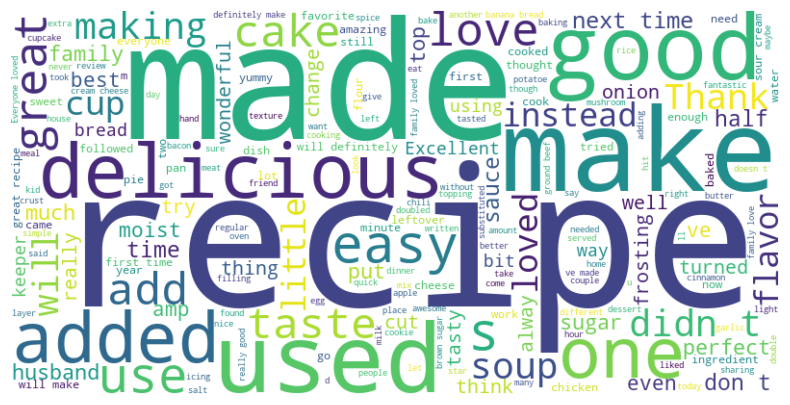

In [254]:
# Create a wordcloud from all the text
text_data = " ".join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [255]:
# Find min and max length of characters in text
min_length = np.inf
max_length = -np.inf

for text in df['text']:
    text_length = len(text)
    if text_length < min_length:
        min_length = text_length
    if text_length > max_length:
        max_length = text_length

print("Minimum length of characters:", min_length)
print("Maximum length of characters:", max_length)

Minimum length of characters: 1
Maximum length of characters: 2742


In [256]:
# Which texts have length 1?
texts_length_1 = []

for index, text in enumerate(df['text']):
    if len(text) == 1:
        texts_length_1.append((index, text))

if texts_length_1:
    print("Observations with text length of 1:")
    for index, text in texts_length_1:
        print(f"Index: {index}, Text: {text}")
else:
    print("No observations with text length of 1.")

Observations with text length of 1:
Index: 22, Text: .
Index: 23, Text: .
Index: 4186, Text: .
Index: 5977, Text: .
Index: 7391, Text: !
Index: 9908, Text:  
Index: 14929, Text:  
Index: 15983, Text: .


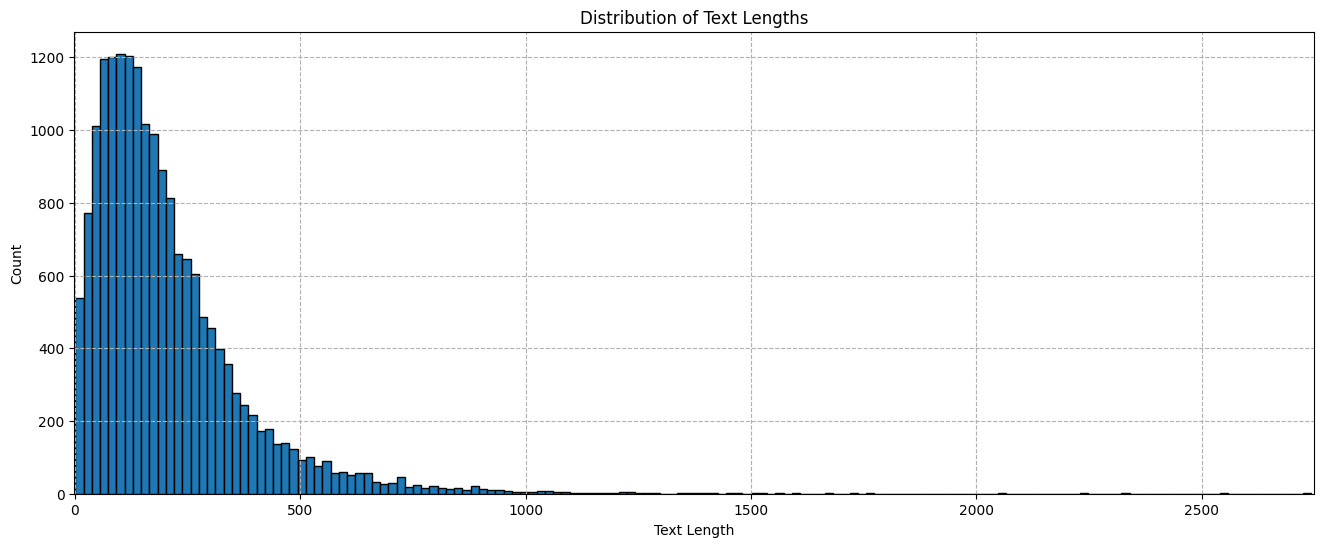

In [257]:
# Plot distribution of text lengths
text_lengths = df['text'].apply(len)

plt.figure(figsize=(16, 6))
plt.hist(text_lengths, bins=150, edgecolor = 'black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xlim(-1,2750)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

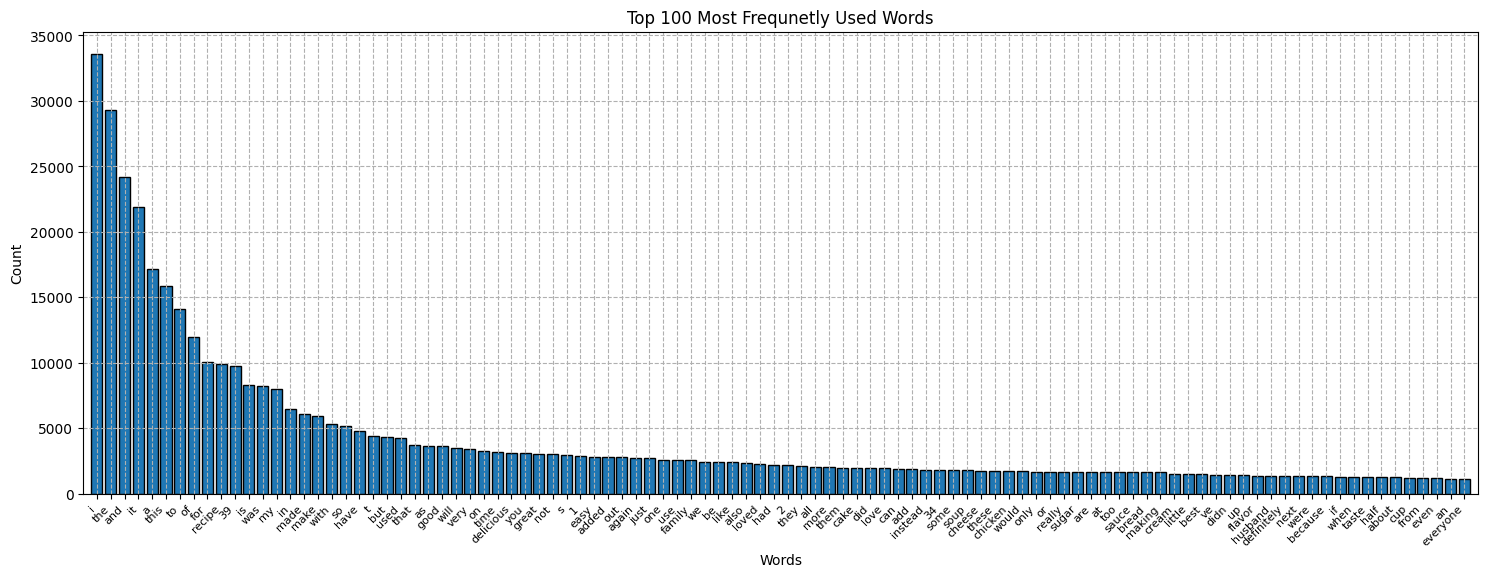

In [258]:
# Plot 100 most frequent words
all_text = ' '.join(df['text'])
words = re.findall(r'\b\w+\b', all_text.lower())

word_counts = Counter(words)
top_100_words = dict(word_counts.most_common(100))
x = np.arange(len(top_100_words))

plt.figure(figsize=(18, 6))
plt.bar(x, top_100_words.values(), edgecolor = 'black')
plt.title('Top 100 Most Frequnetly Used Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(x, top_100_words.keys(), rotation=45, ha='right', fontsize=8)
plt.xlim(-1, 100)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [259]:
# Explore descriptive statistics of user reputations
df['user_reputation'].describe()

count    18180.000000
mean         2.159736
std         10.015210
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        520.000000
Name: user_reputation, dtype: float64

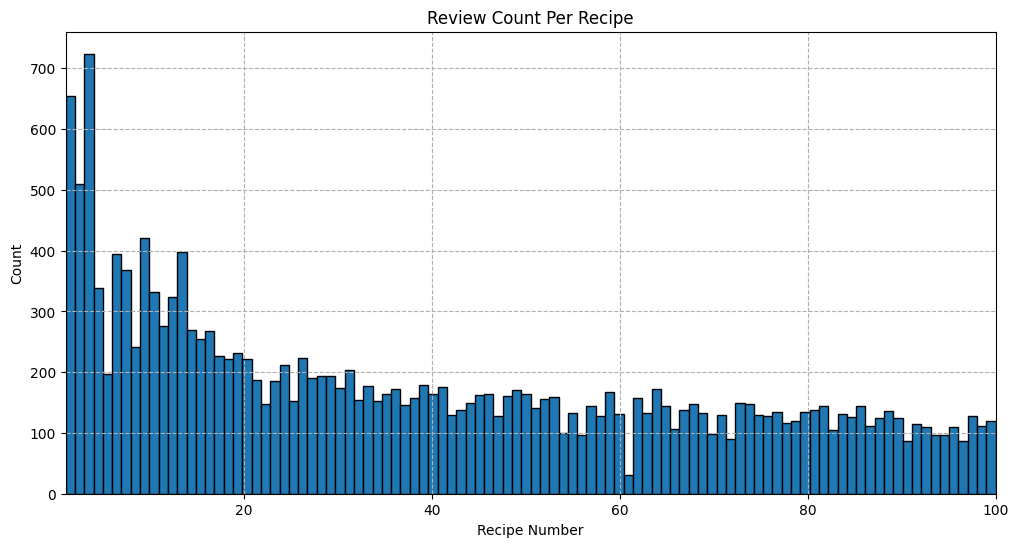

In [260]:
# Plot counts of number of reviews per recipe
plt.figure(figsize = (12,6))
plt.hist(df['recipe_number'], bins = 100, edgecolor = 'black')
plt.title('Review Count Per Recipe')
plt.xlabel('Recipe Number')
plt.ylabel('Count')
plt.xlim(1,100)
plt.grid(True, linestyle='--', zorder=0)
plt.show()

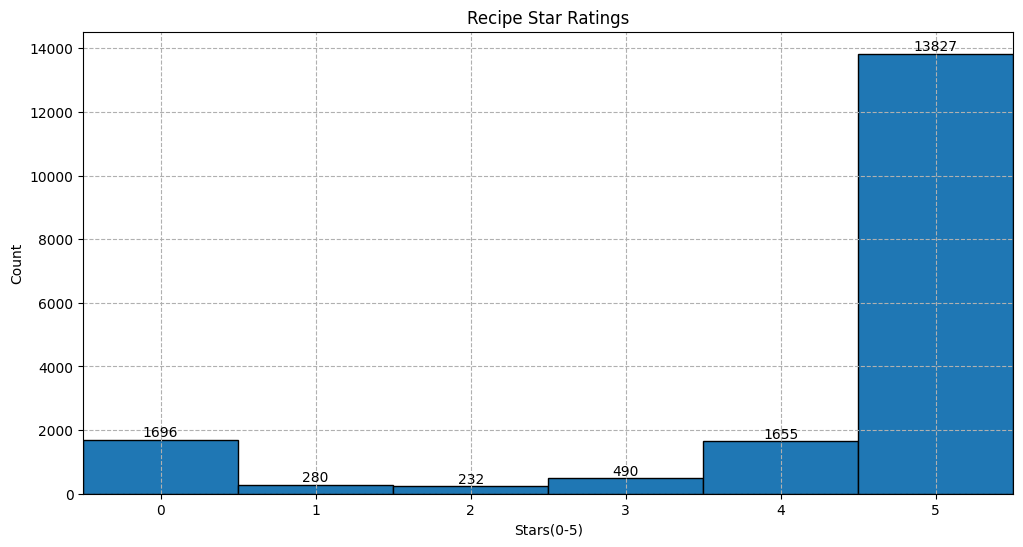

In [261]:
# Check distribution of recipe star ratings
bin_edges = np.arange(-0.5, 6.5, 1)

plt.figure(figsize=(12,6))
counts, bins, _ = plt.hist(df['stars'], bins = bin_edges, edgecolor = 'black', zorder=0)

# Add annotations at the top of each bin
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', va='bottom')

plt.title('Recipe Star Ratings')
plt.xlabel('Stars(0-5)')
plt.ylabel('Count')
plt.xlim(-0.5,5.5)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [262]:
# Get descriptive statistics on votescore
df['votescore'].describe()

count    18180.000000
mean         0.539989
std          4.337018
min       -121.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        103.000000
Name: votescore, dtype: float64

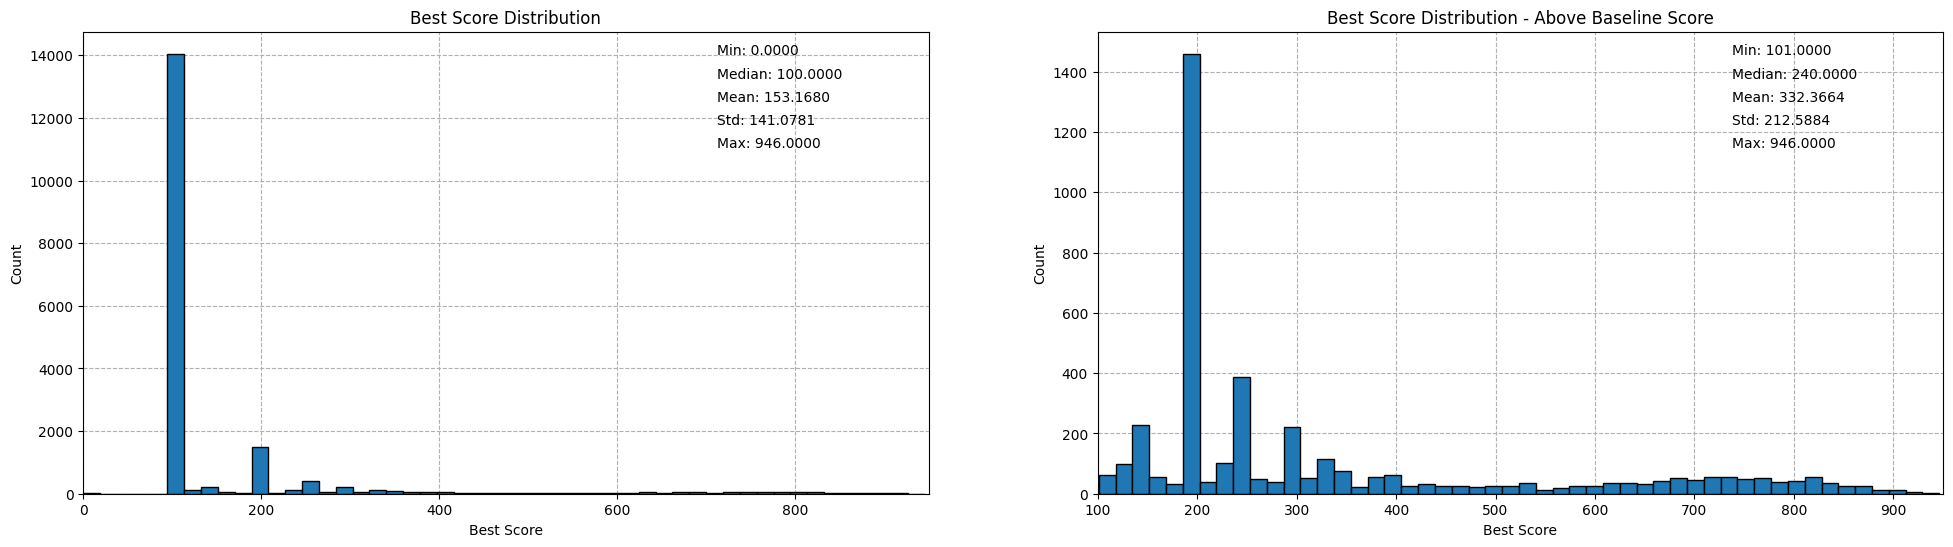

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(24,6))  # 1 row, 2 columns

# Adjust the histograms to plot in the first and second subplot

# First Histogram (for df)
axes[0].hist(df['best_score'], bins=50, edgecolor='black', zorder=2)
axes[0].set_title('Best Score Distribution')
axes[0].set_xlabel('Best Score')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0, 950)
axes[0].grid(True, linestyle='--', zorder=0)

# Adding the stats to the first histogram
stats_df = {
    'Min': np.min(df['best_score']),
    'Median': np.percentile(df['best_score'], 50),
    'Mean': np.mean(df['best_score']),
    'Std': np.std(df['best_score']),
    'Max': np.max(df['best_score'])
}

for i, (key, value) in enumerate(stats_df.items()):
    axes[0].text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=axes[0].transAxes)

# Second Histogram (for dfAlgoComments)
axes[1].hist(dfAlgoComments['best_score'], bins=50, edgecolor='black', zorder=2)
axes[1].set_title('Best Score Distribution - Above Baseline Score')
axes[1].set_xlabel('Best Score')
axes[1].set_ylabel('Count')
axes[1].set_xlim(100, 950)
axes[1].grid(True, linestyle='--', zorder=0)

# Adding the stats to the second histogram
stats_dfAlgoComments = {
    'Min': np.min(dfAlgoComments['best_score']),
    'Median': np.percentile(dfAlgoComments['best_score'], 50),
    'Mean': np.mean(dfAlgoComments['best_score']),
    'Std': np.std(dfAlgoComments['best_score']),
    'Max': np.max(dfAlgoComments['best_score'])
}

for i, (key, value) in enumerate(stats_dfAlgoComments.items()):
    axes[1].text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=axes[1].transAxes)

plt.show()

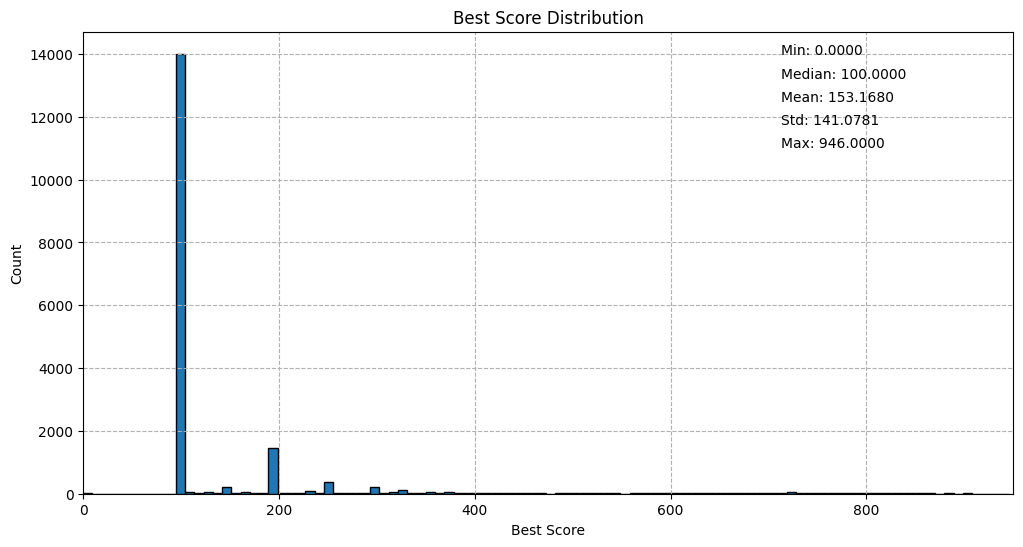

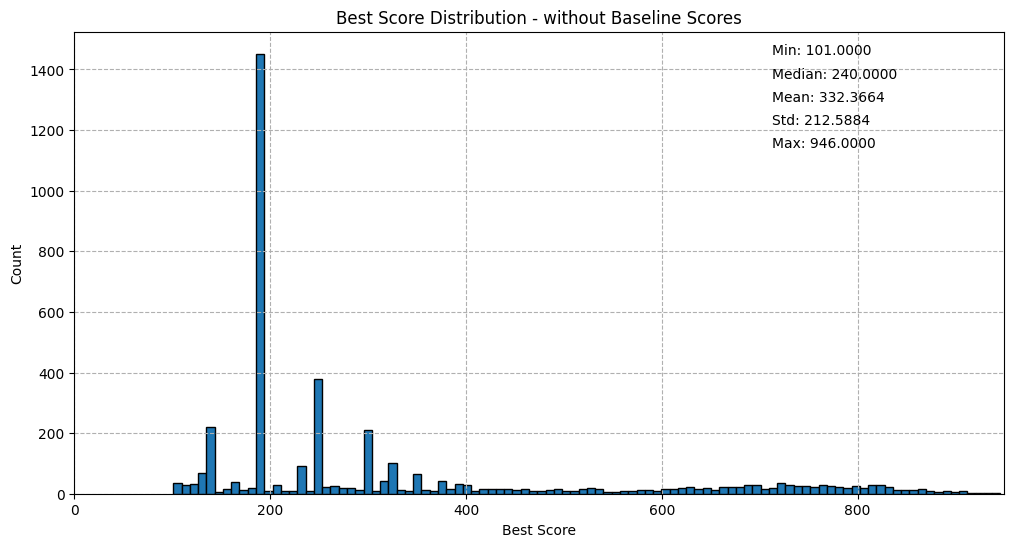

In [264]:
# Plot best_score distribution
plt.figure(figsize = (12,6))
plt.hist(df['best_score'], bins = 100, edgecolor = 'black')
plt.title('Best Score Distribution')
plt.xlabel('Best Score')
plt.ylabel('Count')
plt.xlim(0,950)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['best_score']),
    'Median': np.percentile(df['best_score'], 50),
    'Mean': np.mean(df['best_score']),
    'Std': np.std(df['best_score']),
    'Max': np.max(df['best_score'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

plt.figure(figsize = (12,6))
plt.hist(dfAlgoComments['best_score'], bins = 100, edgecolor = 'black')
plt.title('Best Score Distribution - without Baseline Scores')
plt.xlabel('Best Score')
plt.ylabel('Count')
plt.xlim(0,950)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(dfAlgoComments['best_score']),
    'Median': np.percentile(dfAlgoComments['best_score'], 50),
    'Mean': np.mean(dfAlgoComments['best_score']),
    'Std': np.std(dfAlgoComments['best_score']),
    'Max': np.max(dfAlgoComments['best_score'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

#### Explore Sentiment Results

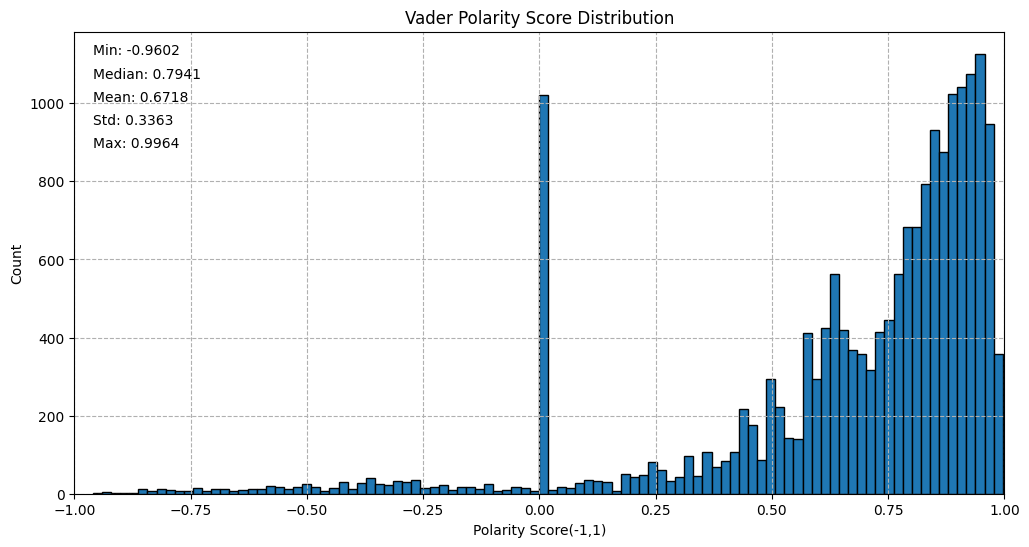

In [265]:
# Plot vader polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_vader'], bins = 100, edgecolor = 'black')
plt.title('Vader Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_vader']),
    'Median': np.percentile(df['polarity_from_vader'], 50),
    'Mean': np.mean(df['polarity_from_vader']),
    'Std': np.std(df['polarity_from_vader']),
    'Max': np.max(df['polarity_from_vader'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

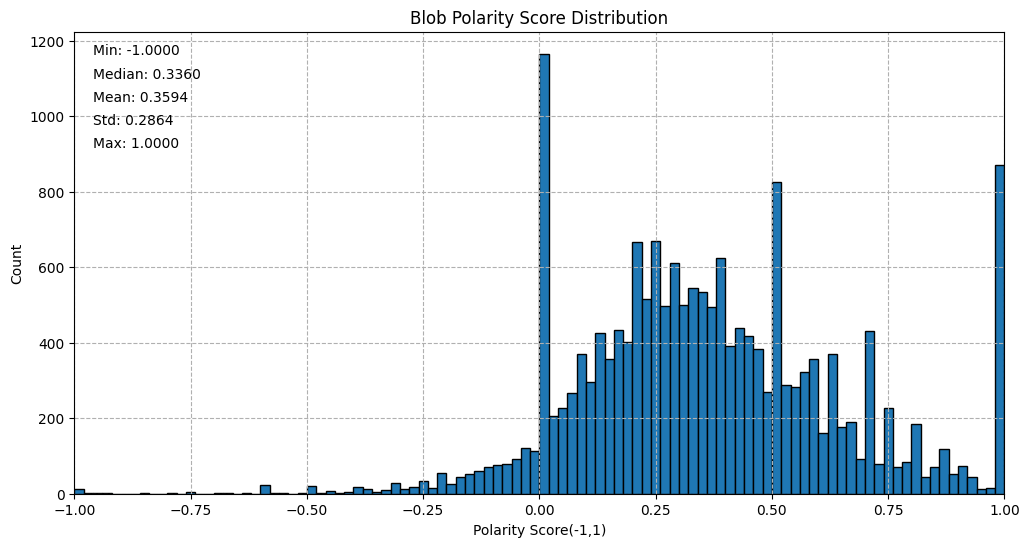

In [266]:
# Plot blob polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_blob'], bins = 100, edgecolor = 'black')
plt.title('Blob Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_blob']),
    'Median': np.percentile(df['polarity_from_blob'], 50),
    'Mean': np.mean(df['polarity_from_blob']),
    'Std': np.std(df['polarity_from_blob']),
    'Max': np.max(df['polarity_from_blob'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

In [267]:
positive_polarity_vader = df[df['polarity_from_vader'] > 0.2]
positive_polarity_blob = df[df['polarity_from_blob'] > 0.2]

print('Vader Positive polarity observations: ', positive_polarity_vader.shape[0])
print('Blob Positive polarity observations: ', positive_polarity_blob.shape[0])

Vader Positive polarity observations:  16201
Blob Positive polarity observations:  12794


In [268]:
neutral_polarity_vader = df[(df['polarity_from_vader'] >= -0.2) & (df['polarity_from_vader'] <= 0.2)]
neutral_polarity_blob = df[(df['polarity_from_blob'] >= -0.2) & (df['polarity_from_blob'] <= 0.2)]


print('Vader Neutral polarity observations: ', neutral_polarity_vader.shape[0])
print('Blob Neutral polarity observations: ', neutral_polarity_blob.shape[0])

Vader Neutral polarity observations:  1388
Blob Neutral polarity observations:  5112


In [269]:
negative_polarity_vader = df[df['polarity_from_vader'] < -0.2]
negative_polarity_blob = df[df['polarity_from_blob'] < -0.2]

print('Vader Negative polarity observations: ', negative_polarity_vader.shape[0])
print('Blob Negative polarity observations: ', negative_polarity_blob.shape[0])

Vader Negative polarity observations:  591
Blob Negative polarity observations:  274


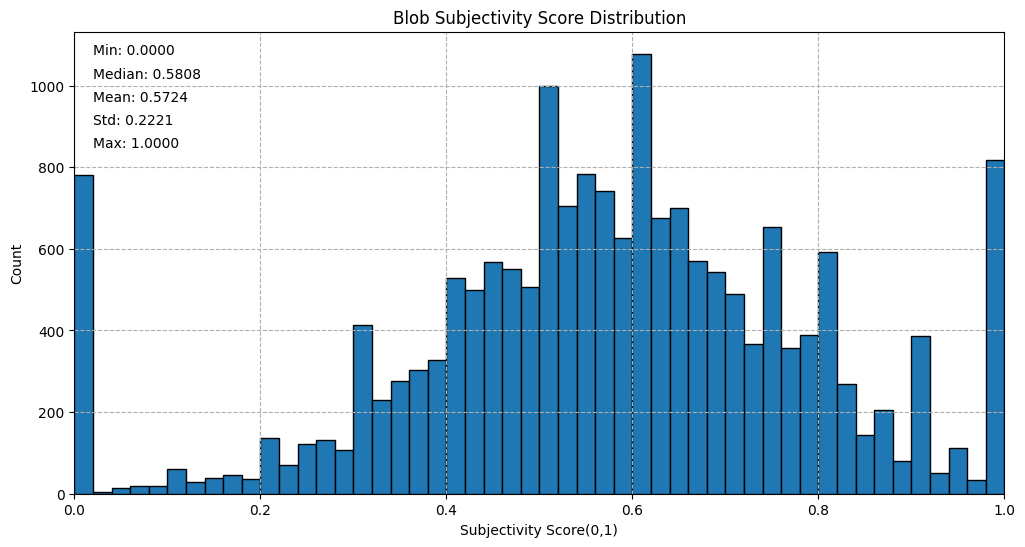

In [270]:
# Take a look at subjectivity from blob
plt.figure(figsize = (12,6))
plt.hist(df['subjectivity'], bins = 50, edgecolor = 'black')
plt.title('Blob Subjectivity Score Distribution')
plt.xlabel('Subjectivity Score(0,1)')
plt.ylabel('Count')
plt.xlim(0,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['subjectivity']),
    'Median': np.percentile(df['subjectivity'], 50),
    'Mean': np.mean(df['subjectivity']),
    'Std': np.std(df['subjectivity']),
    'Max': np.max(df['subjectivity'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()


## Explore Correlation

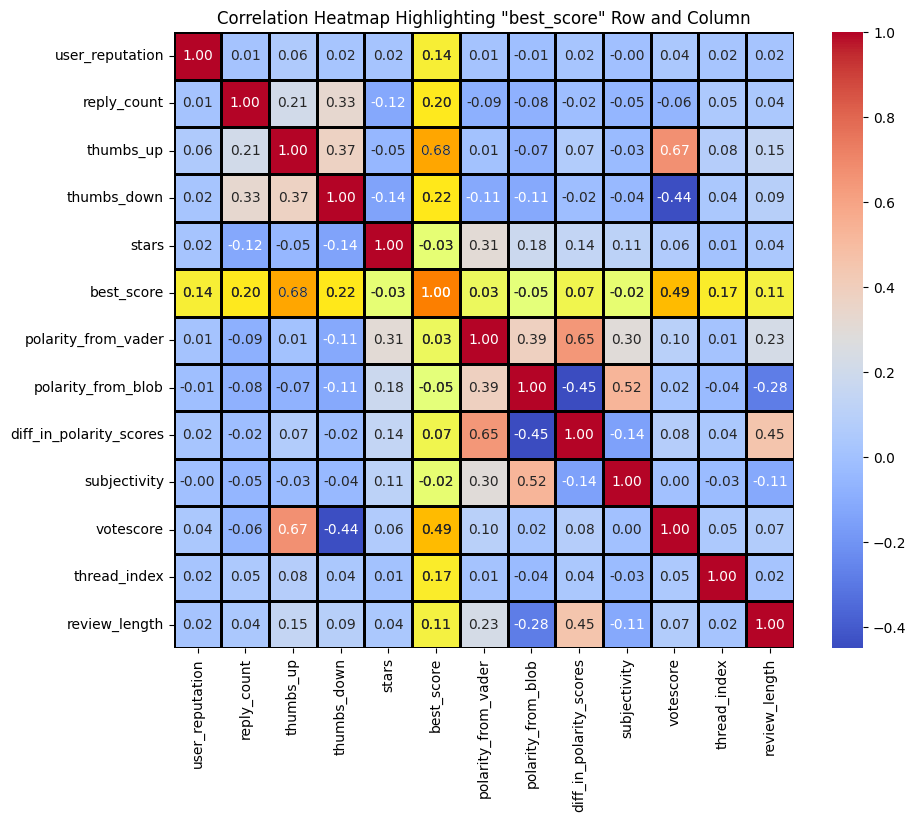

In [271]:
# Plot heatmap of quantitative columns
quant_df = df.select_dtypes(include=['int', 'float']).copy()
quant_df.drop(['recipe_code', 'recipe_number'], axis=1, inplace=True)

corr = quant_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

mask_highlight = np.ones(corr.shape, dtype=bool)  # Initialize mask to keep all elements
highlight_index = corr.columns.get_loc('best_score')  # Get 'best_score' index
mask_highlight[highlight_index, :] = False  # Unmask the 'best_score' row
mask_highlight[:, highlight_index] = False  # Unmask the 'best_score' column

# Using the mask_highlight to overlay the heatmap focusing on 'best_score'
# Note: Adjust cmap, linewidths, linecolor as needed
sns.heatmap(corr, annot=True, cmap='Wistia', fmt=".2f",
            mask=mask_highlight, cbar=False,  # No color bar for the overlay
            linewidths=2, linecolor='black')  # Emphasizes the border for non-masked cells

plt.title('Correlation Heatmap Highlighting "best_score" Row and Column')
plt.show()

## Filtering, Further analysis, and Clustering

In [273]:
print(dfAlgoComments.shape)
print(dfAlgoUsers.shape)

(4165, 22)
(1246, 22)


In [274]:
# Look at comment_length descriptive statistics
print('AlgoComments: Comment length', '\n', dfAlgoComments['comment_length'].describe(), '\n')
print('AlgoUsers: Comment length', '\n', dfAlgoUsers['comment_length'].describe())

AlgoComments: Comment length 
 count    4165.000000
mean      257.992797
std       208.991023
min         4.000000
25%       117.000000
50%       212.000000
75%       334.000000
max      2548.000000
Name: comment_length, dtype: float64 

AlgoUsers: Comment length 
 count    1246.000000
mean      233.450241
std       196.387173
min         2.000000
25%       110.000000
50%       190.000000
75%       298.000000
max      2322.000000
Name: comment_length, dtype: float64


In [275]:
# More descriptive statistics on AlgoComments
print('AlgoComments: Best score', '\n', dfAlgoComments['best_score'].describe(), '\n')
print('AlgoComments: User reputation', '\n', dfAlgoComments['user_reputation'].describe())

AlgoComments: Best score 
 count    4165.000000
mean      332.366387
std       212.613947
min       101.000000
25%       193.000000
50%       240.000000
75%       395.000000
max       946.000000
Name: best_score, dtype: float64 

AlgoComments: User reputation 
 count    4165.000000
mean        3.933974
std        19.908212
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       520.000000
Name: user_reputation, dtype: float64


In [276]:
# More descriptive statistics on AlgoUsers
print('AlgoUsers: Best score', '\n', dfAlgoUsers['best_score'].describe(), '\n')
print('AlgoUsers: User reputation', '\n', dfAlgoUsers['user_reputation'].describe())

AlgoUsers: Best score 
 count    1246.000000
mean      223.271268
std       199.913625
min         0.000000
25%       100.000000
50%       100.000000
75%       258.000000
max       934.000000
Name: best_score, dtype: float64 

AlgoUsers: User reputation 
 count    1246.000000
mean       17.921348
std        34.607568
min         0.000000
25%        10.000000
50%        10.000000
75%        20.000000
max       520.000000
Name: user_reputation, dtype: float64


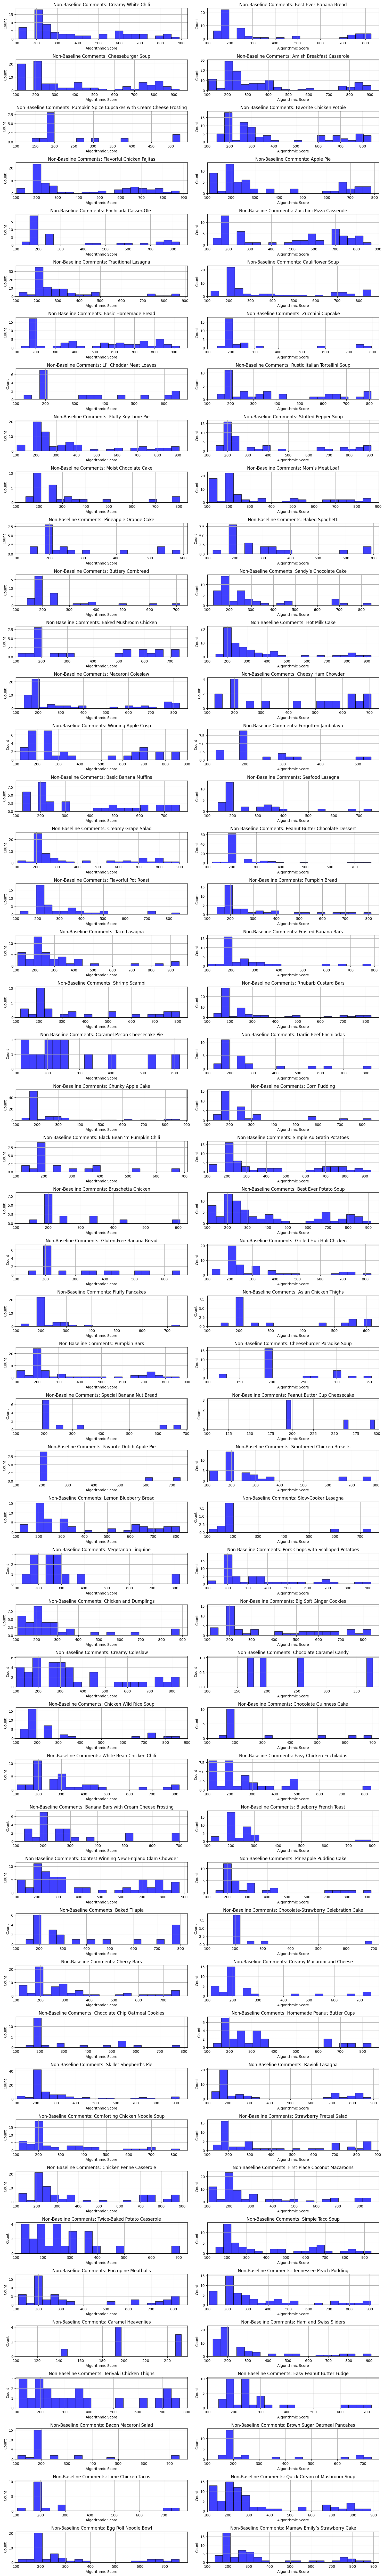

In [277]:
# Take look at filtered best_scores DF per recipe
recipeNames = df['recipe_name'].unique()

num_cols = 2  # number of columns
num_rows = 50  # number of rows

plt.figure(figsize=(15, 100))

# iterate over recipe names and plot histograms
for idx, names in enumerate(recipeNames, start=1):
    recipeFrame = dfAlgoComments[dfAlgoComments['recipe_name'] == names]
    plt.subplot(num_rows, num_cols, idx)
    recipeFrame['best_score'].hist(bins=20, alpha=0.75, color='blue', edgecolor='black')
    plt.title(f"Non-Baseline Comments: {names}")
    plt.xlabel("Algorithmic Score")
    plt.xlim(100, None)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


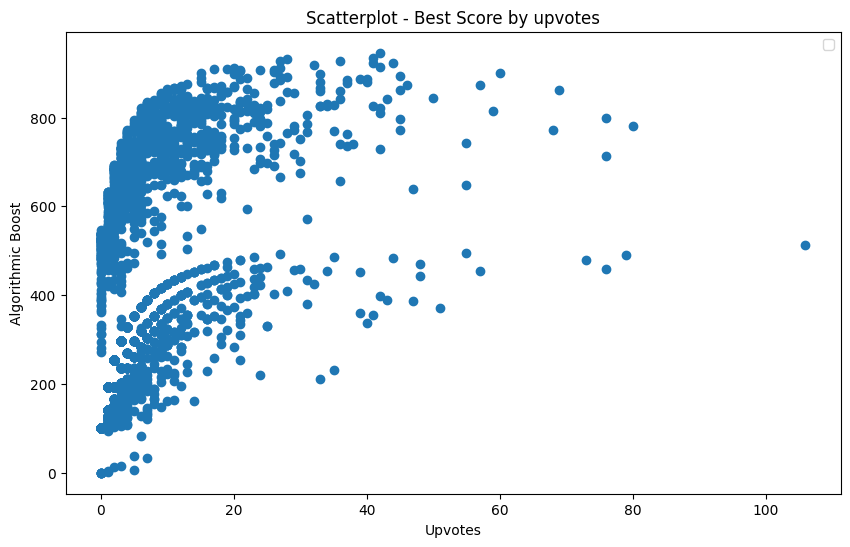

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


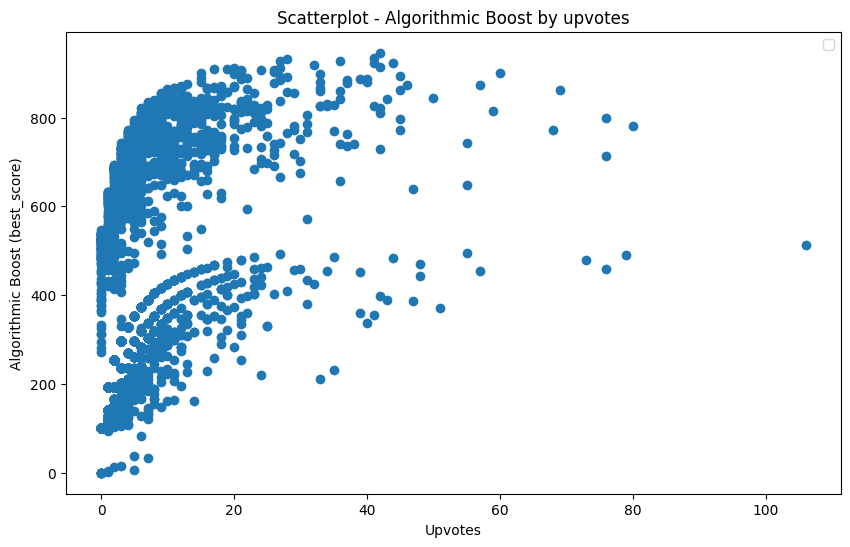

In [302]:
plt.figure(figsize=(10, 6))

# Scatter plot of the data with color-coding for clusters
plt.scatter(df['thumbs_up'], df['best_score'])

# Plot the cluster centers
plt.title('Scatterplot - Best Score by upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Algorithmic Boost')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10, 6))

# Scatter plot of the data with color-coding for clusters
plt.scatter(df['thumbs_up'], df['best_score'])

# Plot the cluster centers
plt.title('Scatterplot - Algorithmic Boost by upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Algorithmic Boost (best_score)')
plt.legend(loc='best')
plt.show()

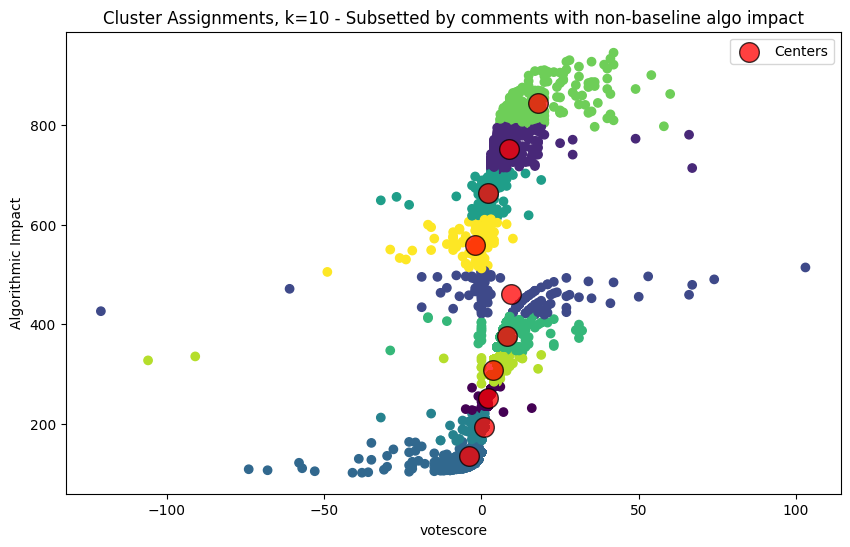

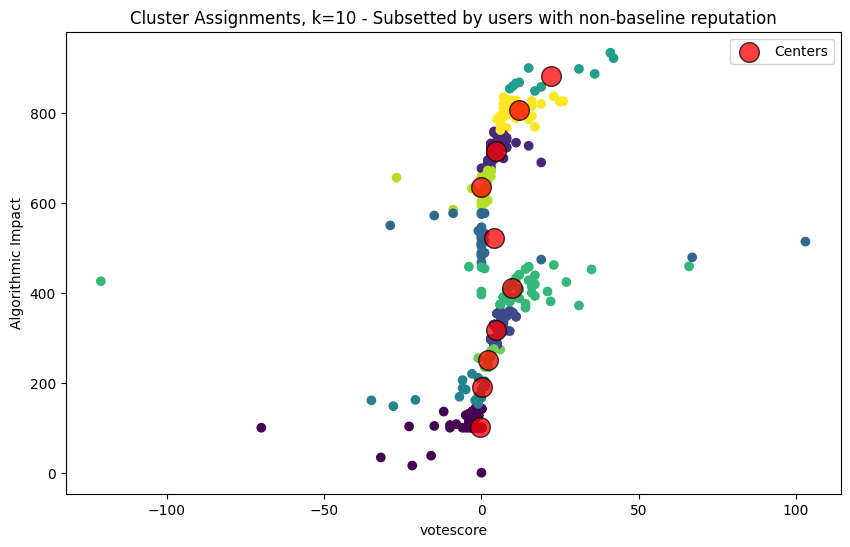

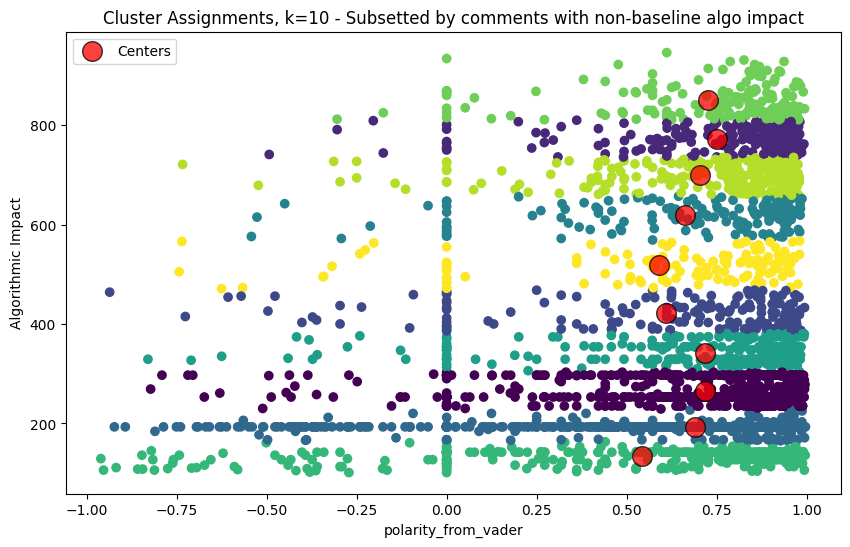

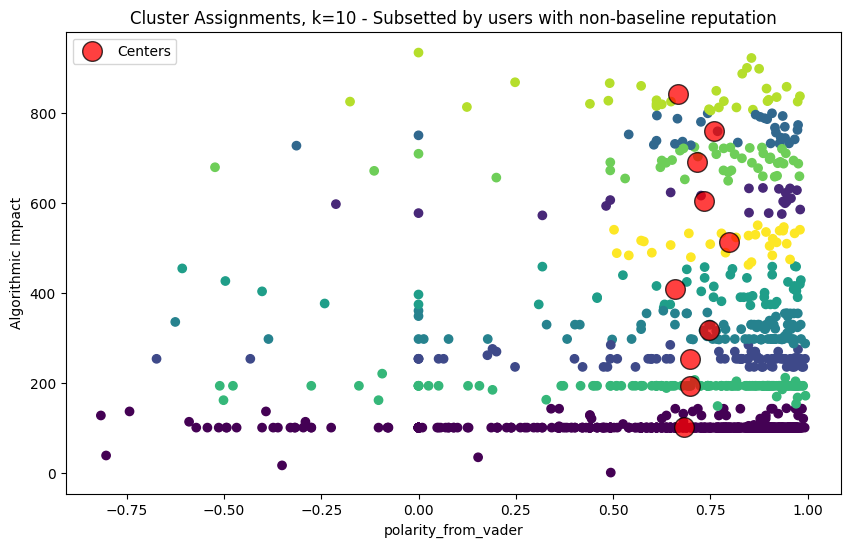

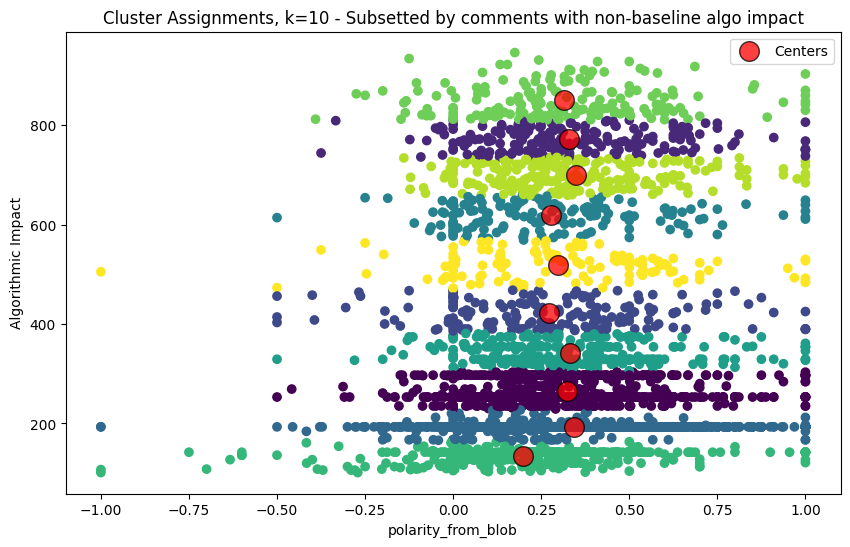

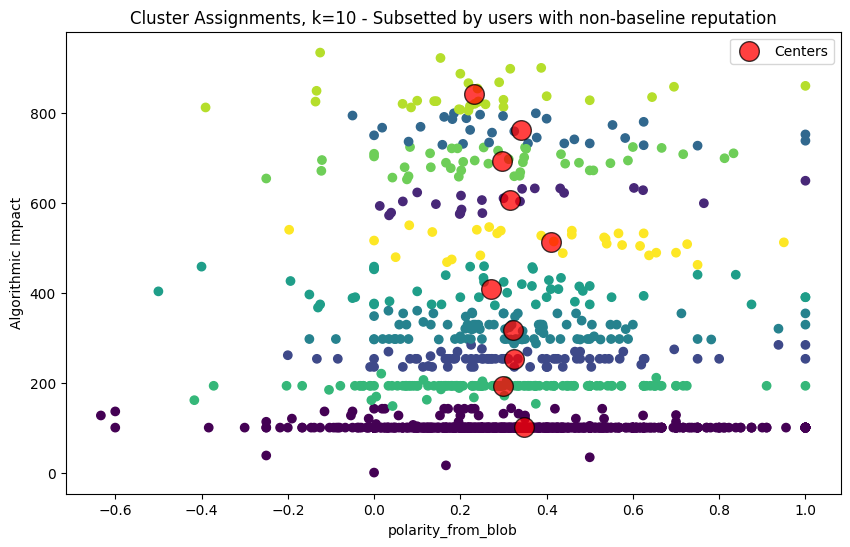

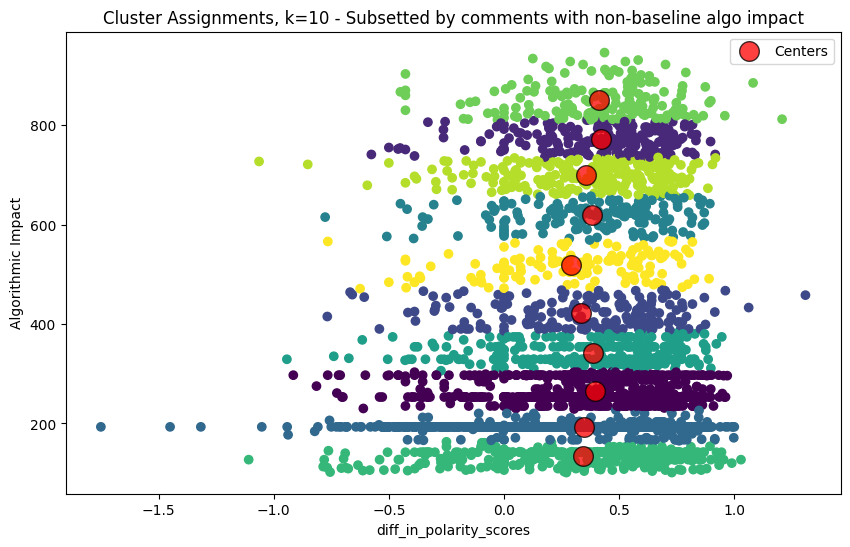

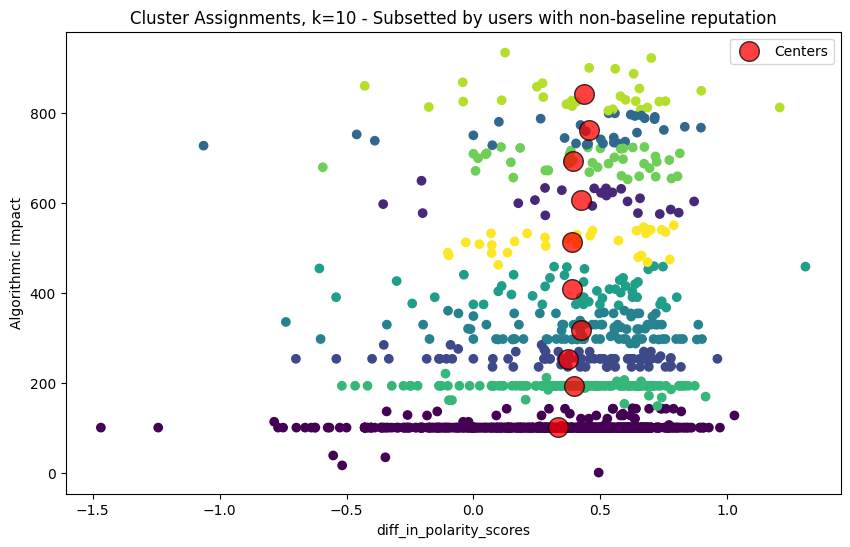

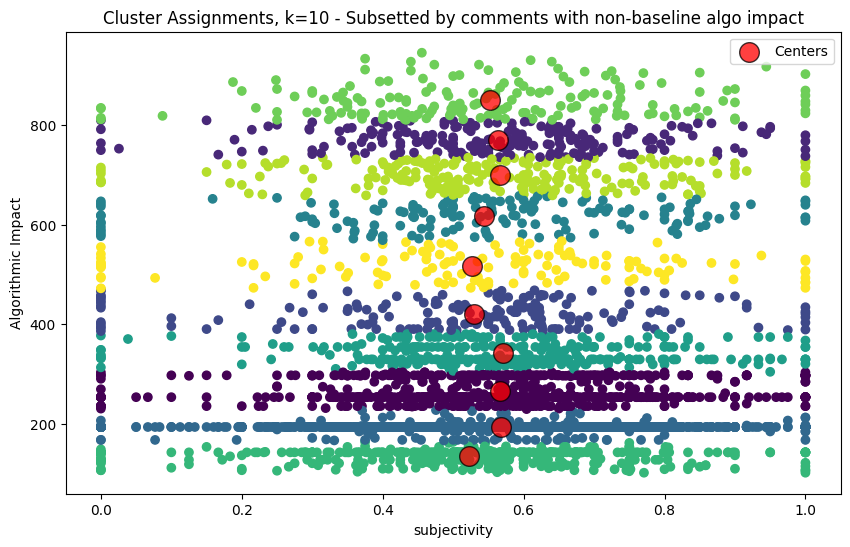

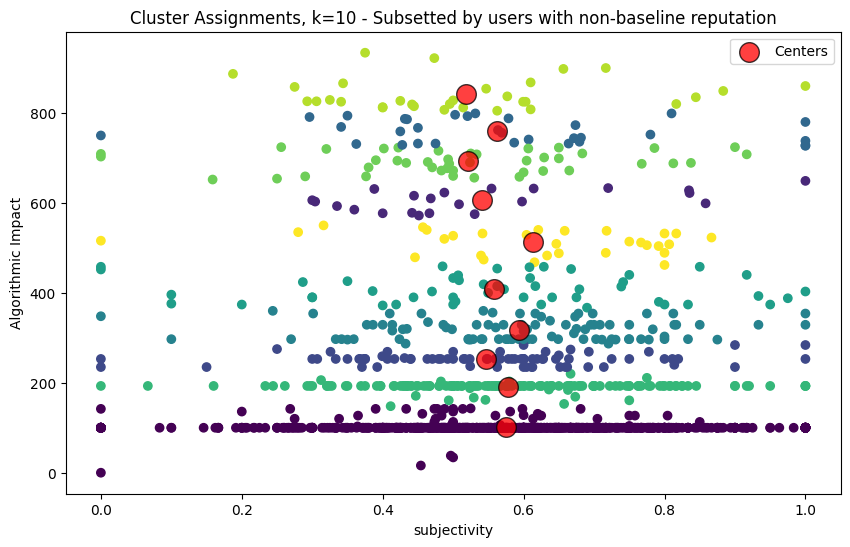

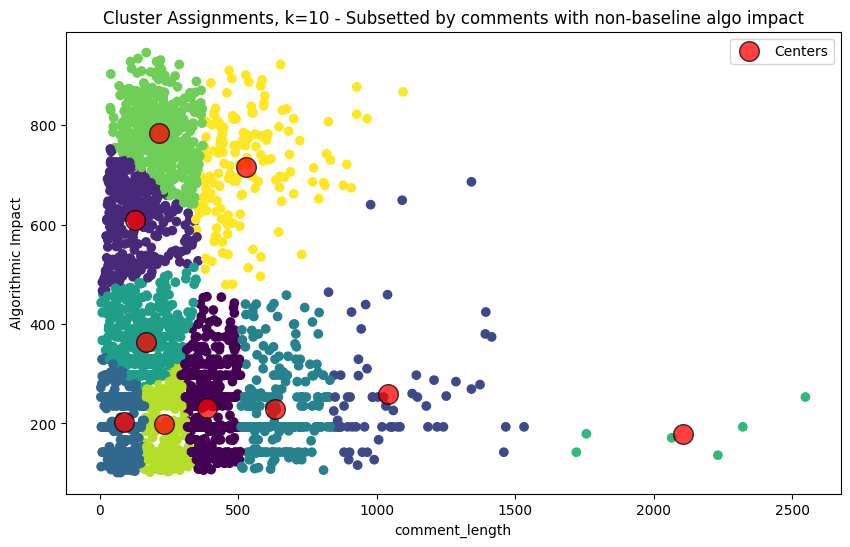

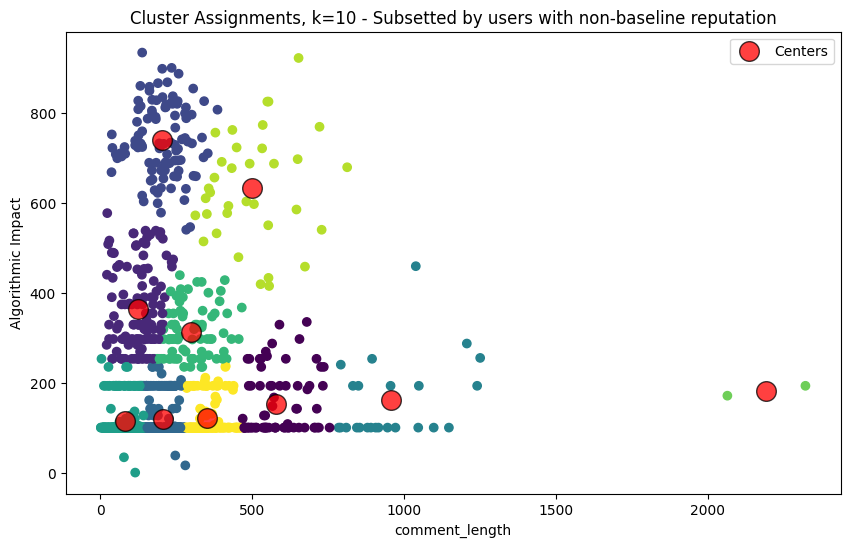

In [278]:
# Run K-Means (K=10) on AlgoComments and AlgoUsers
toTest = ['votescore', 'polarity_from_vader', 'polarity_from_blob', 'diff_in_polarity_scores', 'subjectivity', 'comment_length']
for param in toTest:

    kmeansDF = dfAlgoComments[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by comments with non-baseline algo impact')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

    kmeansDF = dfAlgoUsers[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by users with non-baseline reputation')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

## Predicting best_score Without Sentiment

In [279]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#### Split Data for Non-Sentiment Predictions

In [280]:
X = df.drop(columns=['recipe_number', 'recipe_code', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'created_at', 'stars', 'text', 'polarity_from_vader', 'polarity_from_blob', 'diff_in_polarity_scores', 'subjectivity', 'best_score', 'thread_index', 'review_length', 'votescore'])
y = df['best_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Train, Cross validate, and Test MLPRegressor (without Sentiment)

In [281]:
param_grid = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001, 0.01]
    }

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('mlp', MLPRegressor(max_iter=1500, random_state = 42))
])

# Perform grid search with 5-fold cross-validation
mlp_nosent_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, return_train_score=True)
mlp_nosent_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=   4.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=   4.8s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=   5.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=   5.5s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=   6.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=   7.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=   8.4s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solve

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp',
                                        MLPRegressor(max_iter=1500,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(100,), (100, 50),
                                                     (50, 50)],
                         'mlp__solver': ['adam']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [282]:
# Look at results and fit best model
cv_results = mlp_nosent_grid_search.cv_results_
for i in range(len(cv_results["params"])):
    print("Fit", i+1, ":", cv_results["params"][i], "Average MAE:", -cv_results["mean_test_score"][i])

print("Best parameters found:", mlp_nosent_grid_search.best_params_)

# Set best parameters to final pipeline
mlp_nosent_best_model = mlp_nosent_grid_search.best_estimator_

# Evaluate the best pipeline on the test set
pipeline_y_pred = mlp_nosent_best_model.predict(X_test)

mlp_nosent_mae = mean_absolute_error(y_test, pipeline_y_pred)
mlp_nosent_mse = mean_squared_error(y_test, pipeline_y_pred)
mlp_nosent_rmse = root_mean_squared_error(y_test, pipeline_y_pred)

print("Mean Absolute Error (MAE) on test set:", mlp_nosent_mae)
print("Mean Squared Error (MSE) on test set:", mlp_nosent_mse)
print("Root Mean Squared Error (RMSE) on test set:", mlp_nosent_rmse)

Fit 1 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'} Average MAE: 26.766124688046308
Fit 2 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} Average MAE: 26.234750007153195
Fit 3 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam'} Average MAE: 25.78606962890148
Fit 4 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'} Average MAE: 26.777050083278606
Fit 5 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} Average MAE: 24.33322904172429
Fit 6 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam'} Average MAE: 25.402663553007738
Fit 7 : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': '

### Train, Cross Validate, and Test GBRegressor (without Sentiment)

In [283]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GBRegressor
gb_regressor = GradientBoostingRegressor(random_state = 42)

# Perform grid search with 5-fold cross-validation
gb_nosent_grid_search = GridSearchCV(gb_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
gb_nosent_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   0.4s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   0.2s
[CV] END ................learning_rate=0.1, n_est

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [284]:
# Look at results and fit best model
cv_results = gb_nosent_grid_search.cv_results_
for i in range(len(cv_results["params"])):
    print("Fit", i+1, ":", cv_results["params"][i], "Average MAE:", -cv_results["mean_test_score"][i])

print("Best parameters found:", gb_nosent_grid_search.best_params_)

# Set best parameters to final GBRegressor
best_gb = gb_nosent_grid_search.best_estimator_

# Evaluate the best GBRegressor on the test set
gb_y_pred = best_gb.predict(X_test)

gb_nosent_mae = mean_absolute_error(y_test, gb_y_pred)
gb_nosent_mse = mean_squared_error(y_test, gb_y_pred)
gb_nosent_rmse = root_mean_squared_error(y_test, gb_y_pred)

print("Mean Absolute Error (MAE) on test set:", gb_nosent_mae)
print("Mean Squared Error (MSE) on test set:", gb_nosent_mse)
print("Root Mean Squared Error (RMSE) on test set:", gb_nosent_rmse)

Fit 1 : {'learning_rate': 0.01, 'n_estimators': 100} Average MAE: 39.547495067453
Fit 2 : {'learning_rate': 0.01, 'n_estimators': 200} Average MAE: 28.954604310093494
Fit 3 : {'learning_rate': 0.01, 'n_estimators': 300} Average MAE: 26.12806160565119
Fit 4 : {'learning_rate': 0.1, 'n_estimators': 100} Average MAE: 24.127049626471123
Fit 5 : {'learning_rate': 0.1, 'n_estimators': 200} Average MAE: 24.014416463088146
Fit 6 : {'learning_rate': 0.1, 'n_estimators': 300} Average MAE: 24.141366492050835
Fit 7 : {'learning_rate': 0.2, 'n_estimators': 100} Average MAE: 24.061942768955998
Fit 8 : {'learning_rate': 0.2, 'n_estimators': 200} Average MAE: 24.249737667829116
Fit 9 : {'learning_rate': 0.2, 'n_estimators': 300} Average MAE: 24.398498018023314
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200}
Mean Absolute Error (MAE) on test set: 24.618248487582427
Mean Squared Error (MSE) on test set: 5140.402459964391
Root Mean Squared Error (RMSE) on test set: 71.6966000586108


## Predicting best_score With Sentiment (Polarity and Subjectivity Scores)

#### Stratification on Vader Polarity Score

- For equal custom defined proportions

In [285]:
X = df.drop(columns=['recipe_number', 'recipe_code', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'created_at', 'stars', 'text', 'diff_in_polarity_scores', 'best_score'])
y = df['best_score']

X_pos = X[(X['polarity_from_vader'] > 0.2) & (X['polarity_from_vader'] <= 1)]
y_pos = y[X_pos.index]

X_neut = X[(X['polarity_from_vader'] >= -0.2) & (X['polarity_from_vader'] <= 0.2)]
y_neut = y[X_neut.index]

X_neg = X[(X['polarity_from_vader'] >= -1) & (X['polarity_from_vader'] < -0.2)]
y_neg = y[X_neg.index]

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.2, random_state=42)
X_train_neut, X_test_neut, y_train_neut, y_test_neut = train_test_split(X_neut, y_neut, test_size=0.2, random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.2, random_state=42)

X_train = pd.concat([X_train_pos, X_train_neut, X_train_neg])
y_train = pd.concat([y_train_pos, y_train_neut, y_train_neg])
X_test = pd.concat([X_test_pos, X_test_neut, X_test_neg])
y_test = pd.concat([y_test_pos, y_test_neut, y_test_neg])

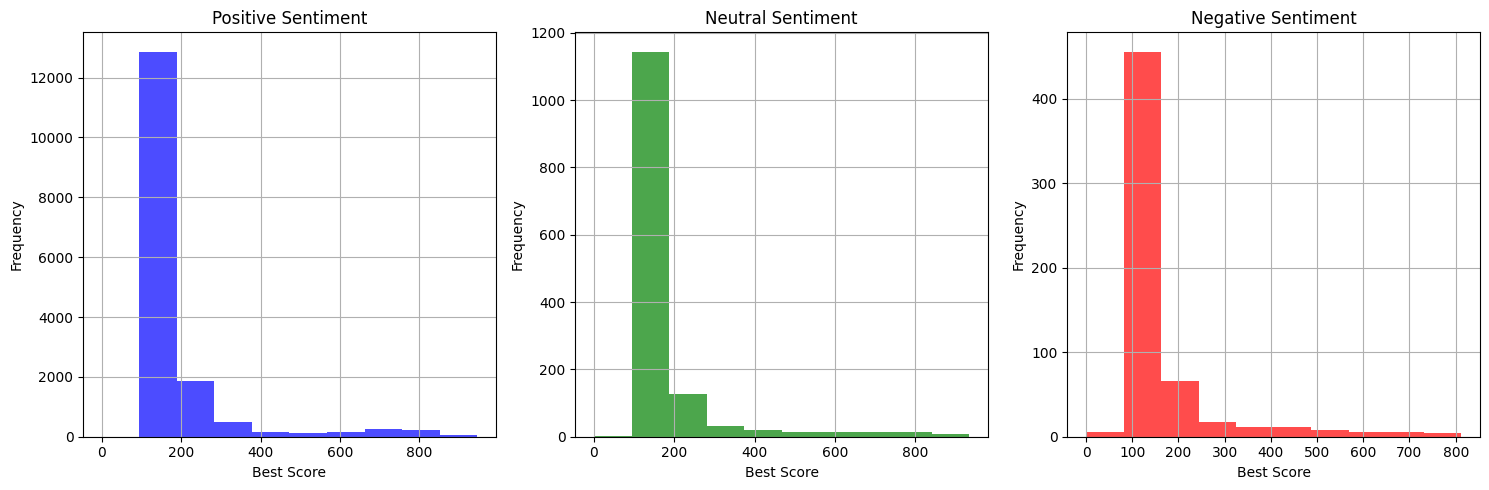

In [286]:
# Plot histograms for positive, neutral, and negative sentiment best scores
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(y_pos, color='blue', alpha=0.7)
axs[0].set_title('Positive Sentiment')
axs[0].set_xlabel('Best Score')
axs[0].set_ylabel('Frequency')
axs[0].grid()

axs[1].hist(y_neut, color='green', alpha=0.7)
axs[1].set_title('Neutral Sentiment')
axs[1].set_xlabel('Best Score')
axs[1].set_ylabel('Frequency')
axs[1].grid()

axs[2].hist(y_neg, color='red', alpha=0.7)
axs[2].set_title('Negative Sentiment')
axs[2].set_xlabel('Best Score')
axs[2].set_ylabel('Frequency')
axs[2].grid()

plt.tight_layout()
plt.show()

### Train, Cross validate, and Test Sentiment Augmented MLPRegressor

In [287]:
param_grid = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('mlp', MLPRegressor(max_iter=1500, random_state = 42))
])

# Perform grid search with 5-fold cross-validation
mlp_sent_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
mlp_sent_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=  12.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=  13.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=  13.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=  14.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam; total time=  14.8s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=  15.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__solver=adam; total time=  15.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__solver=adam

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp',
                                        MLPRegressor(max_iter=1500,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(100,), (100, 50),
                                                     (50, 50)],
                         'mlp__solver': ['adam']},
             scoring='neg_mean_absolute_error', verbose=2)

In [288]:
# Look at results and fit best sentiment model
cv_results = mlp_sent_grid_search.cv_results_
for i in range(len(cv_results["params"])):
    print("Fit", i+1, ":", cv_results["params"][i], "Average MAE:", -cv_results["mean_test_score"][i])

print("Best parameters found:", mlp_sent_grid_search.best_params_)

# Set best parameters to final pipeline
mlp_sent_best_model = mlp_sent_grid_search.best_estimator_

# Evaluate the best pipeline on the test set
pipeline_y_pred = mlp_sent_best_model.predict(X_test)

mlp_sent_mae = mean_absolute_error(y_test, pipeline_y_pred)
mlp_sent_mse = mean_squared_error(y_test, pipeline_y_pred)
mlp_sent_rmse = root_mean_squared_error(y_test, pipeline_y_pred)

print("Mean Absolute Error (MAE) on test set:", mlp_sent_mae)
print("Mean Squared Error (MSE) on test set:", mlp_sent_mse)
print("Root Mean Squared Error (RMSE) on test set:", mlp_sent_rmse)

Fit 1 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'} Average MAE: 26.787659453185533
Fit 2 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} Average MAE: 26.991909612022276
Fit 3 : {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam'} Average MAE: 25.519012652501697
Fit 4 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'} Average MAE: 27.042454223587395
Fit 5 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} Average MAE: 26.56966886785536
Fit 6 : {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam'} Average MAE: 25.920950736489964
Fit 7 : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 

### Train, Cross Validate, and Test Sentiment Augmented GBRegressor

In [289]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GBRegressor
gb_regressor = GradientBoostingRegressor(random_state = 42)

# Perform grid search with 5-fold cross-validation
gb_sent_grid_search = GridSearchCV(gb_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
gb_sent_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.6s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.3s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.3s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.5s
[CV] END ................learning_rate=0.1, n_est

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [290]:
# Look at results and fit best sentiment model
cv_results = gb_sent_grid_search.cv_results_
for i in range(len(cv_results["params"])):
    print("Fit", i+1, ":", cv_results["params"][i], "Average MAE:", -cv_results["mean_test_score"][i])

print("Best parameters found:", gb_sent_grid_search.best_params_)

# Set best parameters to final GBRegressor
best_gb = gb_sent_grid_search.best_estimator_

# Evaluate the best GBRegressor on the test set
gb_sent_y_pred = best_gb.predict(X_test)

gb_sent_mae = mean_absolute_error(y_test, gb_sent_y_pred)
gb_sent_mse = mean_squared_error(y_test, gb_sent_y_pred)
gb_sent_rmse = root_mean_squared_error(y_test, gb_sent_y_pred)

print("Mean Absolute Error (MAE) on test set:", gb_sent_mae)
print("Mean Squared Error (MSE) on test set:", gb_sent_mse)
print("Root Mean Squared Error (RMSE) on test set:", gb_sent_rmse)

Fit 1 : {'learning_rate': 0.01, 'n_estimators': 100} Average MAE: 38.5987203294761
Fit 2 : {'learning_rate': 0.01, 'n_estimators': 200} Average MAE: 27.218628516640543
Fit 3 : {'learning_rate': 0.01, 'n_estimators': 300} Average MAE: 23.73900322813369
Fit 4 : {'learning_rate': 0.1, 'n_estimators': 100} Average MAE: 21.256383058718622
Fit 5 : {'learning_rate': 0.1, 'n_estimators': 200} Average MAE: 21.826116900116414
Fit 6 : {'learning_rate': 0.1, 'n_estimators': 300} Average MAE: 22.846504764281754
Fit 7 : {'learning_rate': 0.2, 'n_estimators': 100} Average MAE: 22.032691315891164
Fit 8 : {'learning_rate': 0.2, 'n_estimators': 200} Average MAE: 23.057827877186885
Fit 9 : {'learning_rate': 0.2, 'n_estimators': 300} Average MAE: 23.68949048582258
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 100}
Mean Absolute Error (MAE) on test set: 21.445597789318224
Mean Squared Error (MSE) on test set: 4267.630389390989
Root Mean Squared Error (RMSE) on test set: 65.32710302310205


## Diagnosing Results

### MLP Regressor Results

In [291]:
mlp_nosent_results = mlp_nosent_grid_search.cv_results_

mlp_results = []

for params, mean_mae in zip(mlp_nosent_results["params"], mlp_nosent_results["mean_test_score"]):
    params_dict = {
        "Data" : "Original Training",
        "Activation": params["mlp__activation"],
        "Solver": params["mlp__solver"],
        "Alpha": params["mlp__alpha"],
        "Hidden Layer Sizes": params["mlp__hidden_layer_sizes"],
        "MAE": -mean_mae
    }
    mlp_results.append(params_dict)

mlp_sent_results = mlp_sent_grid_search.cv_results_

for params, mean_mae in zip(mlp_sent_results["params"], mlp_sent_results["mean_test_score"]):
    params_dict = {
        "Data": "Augmented Training",
        "Activation": params["mlp__activation"],
        "Solver": params["mlp__solver"],
        "Alpha": params["mlp__alpha"],
        "Hidden Layer Sizes": params["mlp__hidden_layer_sizes"],
        "MAE": -mean_mae
    }
    mlp_results.append(params_dict)

mlp_df = pd.DataFrame(mlp_results)
mlp_df


Data Activation Solver   Alpha Hidden Layer Sizes        MAE
0    Original Training       relu   adam  0.0001             (100,)  26.766125
1    Original Training       relu   adam  0.0001          (100, 50)  26.234750
2    Original Training       relu   adam  0.0001           (50, 50)  25.786070
3    Original Training       relu   adam  0.0010             (100,)  26.777050
4    Original Training       relu   adam  0.0010          (100, 50)  24.333229
5    Original Training       relu   adam  0.0010           (50, 50)  25.402664
6    Original Training       relu   adam  0.0100             (100,)  26.784947
7    Original Training       relu   adam  0.0100          (100, 50)  25.231368
8    Original Training       relu   adam  0.0100           (50, 50)  25.983610
9   Augmented Training       relu   adam  0.0001             (100,)  26.787659
10  Augmented Training       relu   adam  0.0001          (100, 50)  26.991910
11  Augmented Training       relu   adam  0.0001           (50, 50)  25.519013
12  Augmented Training       relu   adam  0.0010             (100,)  27.042454
13  Augmented Training       relu   adam  0.0010          (100, 50)  26.569669
14  Augmented Training       relu   adam  0.0010           (50, 50)  25.920951
15  Augmented Training       relu   adam  0.0100             (100,)  26.806001
16  Augmented Training       relu   adam  0.0100          (100, 50)  27.579605
17  Augmented Training       relu   adam  0.0100           (50, 50)  25.816805

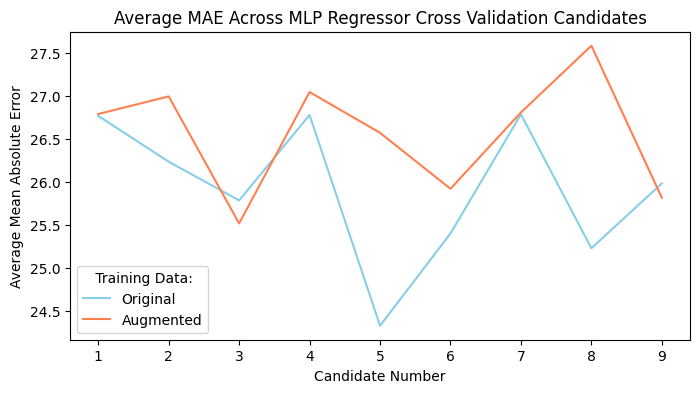

In [292]:
first_mlp = mlp_df[mlp_df["Data"] == "Original Training"]
sec_mlp = mlp_df[mlp_df["Data"] == "Augmented Training"]

plt.figure(figsize = (8,4))
plt.plot(first_mlp.index + 1, first_mlp['MAE'], label='Original', color = 'skyblue')
plt.plot(first_mlp.index + 1, sec_mlp['MAE'], label='Augmented', color = 'coral')
plt.xlabel('Candidate Number')
plt.ylabel('Average Mean Absolute Error')
plt.legend(title = " Training Data:")
plt.title('Average MAE Across MLP Regressor Cross Validation Candidates')
plt.show()

In [293]:
print("MLP Regressor with Original Data:")
print("Testing Mean Absolute Error:", mlp_nosent_mae)
print("Testing Mean Squared Error:", mlp_nosent_mse, "\n")

print("MLP Regressor with Augmented Data:")
print("Testing Mean Absolute Error:", mlp_sent_mae)
print("Testing Mean Squared Error:", mlp_sent_mse, "\n")

print("Results:")
print("Augmented Data Improvement in MAE:", mlp_nosent_mae - mlp_sent_mae)
print("Augmented Data Improvement in MSE:", mlp_nosent_mse - mlp_sent_mse)

MLP Regressor with Original Data:
Testing Mean Absolute Error: 25.286357591042318
Testing Mean Squared Error: 5243.954548155373 

MLP Regressor with Augmented Data:
Testing Mean Absolute Error: 22.67248261867346
Testing Mean Squared Error: 4354.440269012369 

Results:
Augmented Data Improvement in MAE: 2.6138749723688584
Augmented Data Improvement in MSE: 889.5142791430044


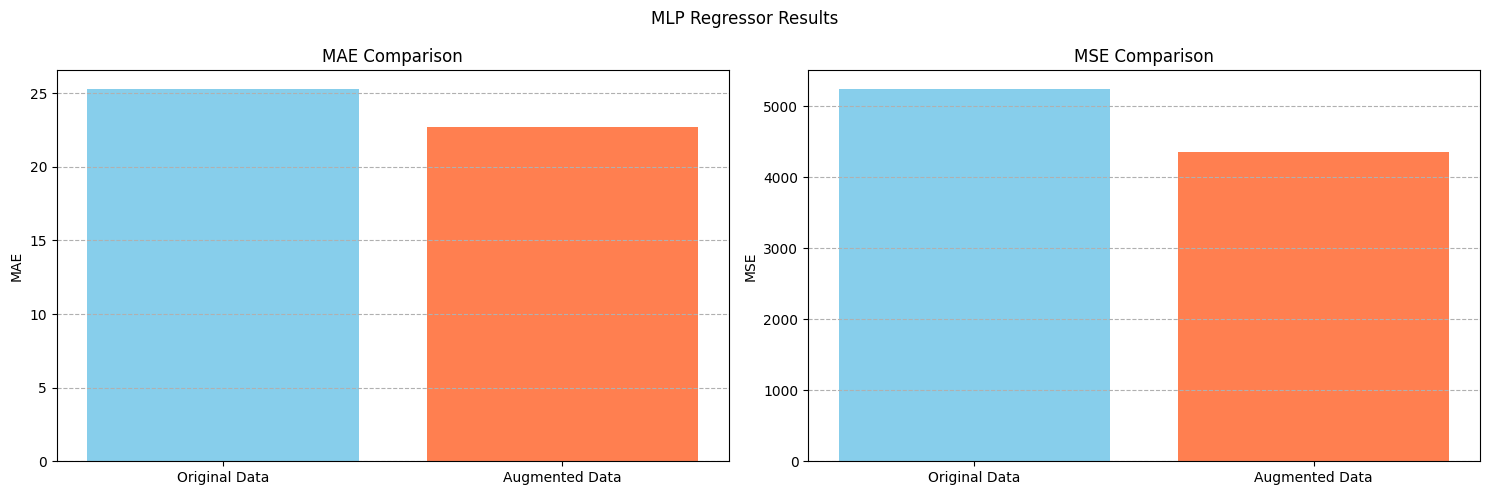

In [294]:
mlp_res = []

mlp_res.append(mlp_nosent_mae)
mlp_res.append(mlp_sent_mae)
mlp_res.append(mlp_nosent_mse)
mlp_res.append(mlp_sent_mse)
mlp_res = pd.DataFrame(mlp_res)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

categories = ['Original Data', 'Augmented Data']
values_mae = [mlp_res.iloc[0, 0], mlp_res.iloc[1, 0]]
values_mse = [mlp_res.iloc[2, 0], mlp_res.iloc[3, 0]]

axes[0].bar(categories, values_mae, color=['skyblue', 'coral'])
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('MAE')
axes[0].grid(axis='y', linestyle='--', zorder=0)

axes[1].bar(categories, values_mse, color=['skyblue', 'coral'])
axes[1].set_title('MSE Comparison')
axes[1].set_ylabel('MSE')
axes[1].grid(axis='y', linestyle='--', zorder=0)

plt.suptitle('MLP Regressor Results');
plt.tight_layout()
plt.show()

### GB Regressor Results

In [ ]:
gb_nosent_results = gb_nosent_grid_search.cv_results_

gb_results = []

for params, mean_mae in zip(gb_nosent_results["params"], gb_nosent_results["mean_test_score"]):
    params_dict = {
        "Data" : "Original Training",
        'Estimators': params['n_estimators'],
        'Learning Rate' : params['learning_rate'],
        "MAE": -mean_mae
    }
    gb_results.append(params_dict)

gb_sent_results = gb_sent_grid_search.cv_results_

for params, mean_mae in zip(gb_sent_results["params"], gb_sent_results["mean_test_score"]):
    params_dict = {
        "Data": "Augmented Training",
        'Estimators': params['n_estimators'],
        'Learning Rate' : params['learning_rate'],
        "MAE": -mean_mae
    }
    gb_results.append(params_dict)


gb_df = pd.DataFrame(gb_results)
gb_df

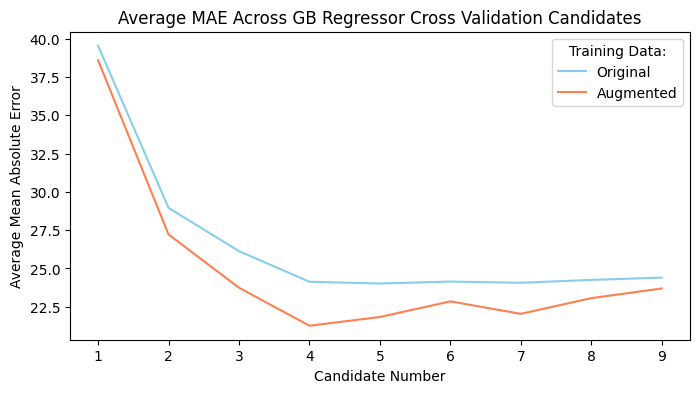

In [296]:
first_gb = gb_df[gb_df["Data"] == "Original Training"]
sec_gb = gb_df[gb_df["Data"] == "Augmented Training"]

plt.figure(figsize = (8,4))
plt.plot(first_gb.index + 1, first_gb['MAE'], label='Original', color = 'skyblue')
plt.plot(first_gb.index + 1, sec_gb['MAE'], label='Augmented', color = 'coral')
plt.xlabel('Candidate Number')
plt.ylabel('Average Mean Absolute Error')
plt.legend(title = "Training Data:")
plt.title('Average MAE Across GB Regressor Cross Validation Candidates')
plt.show()

In [297]:
print("GB Regressor with Original Data:")
print("Testing Mean Absolute Error:", gb_nosent_mae)
print("Testing Mean Squared Error:", gb_nosent_mse, "\n")

print("GB Regressor with Augmented Data:")
print("Testing Mean Absolute Error:", gb_sent_mae)
print("Testing Mean Squared Error:", gb_sent_mse, "\n")

print("Results:")
print("Augmented Data Improvement in MAE:", gb_nosent_mae - gb_sent_mae)
print("Augmented Data Improvement in MSE:", gb_nosent_mse - gb_sent_mse)

GB Regressor with Original Data:
Testing Mean Absolute Error: 24.618248487582427
Testing Mean Squared Error: 5140.402459964391 

GB Regressor with Augmented Data:
Testing Mean Absolute Error: 21.445597789318224
Testing Mean Squared Error: 4267.630389390989 

Results:
Augmented Data Improvement in MAE: 3.172650698264203
Augmented Data Improvement in MSE: 872.7720705734018


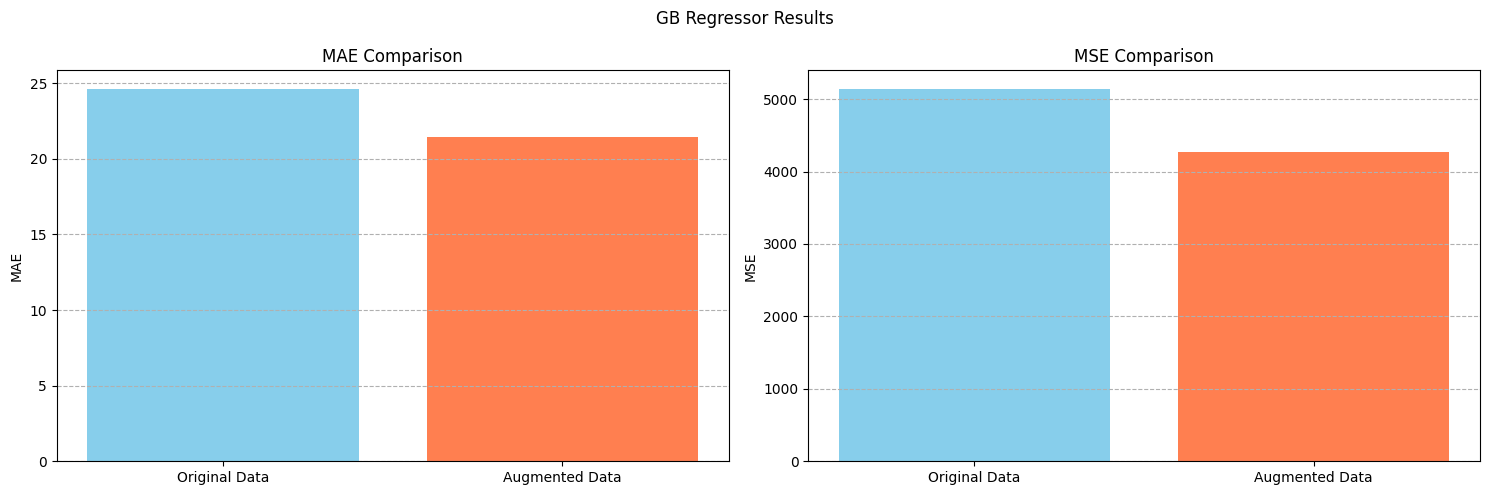

In [298]:
gb_res = []

gb_res.append(gb_nosent_mae)
gb_res.append(gb_sent_mae)
gb_res.append(gb_nosent_mse)
gb_res.append(gb_sent_mse)
gb_res = pd.DataFrame(gb_res)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

categories = ['Original Data', 'Augmented Data']
values_mae = [gb_res.iloc[0, 0], gb_res.iloc[1, 0]]
values_mse = [gb_res.iloc[2, 0], gb_res.iloc[3, 0]]

axes[0].bar(categories, values_mae, color=['skyblue', 'coral'])
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('MAE')
axes[0].grid(axis='y', linestyle='--', zorder=0)

axes[1].bar(categories, values_mse, color=['skyblue', 'coral'])
axes[1].set_title('MSE Comparison')
axes[1].set_ylabel('MSE')
axes[1].grid(axis='y', linestyle='--', zorder=0)

plt.suptitle('GB Regressor Results');
plt.tight_layout()
plt.show()

### Visualizing Final Results

In [299]:
res = []
res.append(mlp_nosent_mae)
res.append(mlp_sent_mae)
res.append(gb_nosent_mae)
res.append(gb_sent_mae)
res.append(mlp_nosent_mse)
res.append(mlp_sent_mse)
res.append(gb_nosent_mse)
res.append(gb_sent_mse)
res = pd.DataFrame(res)

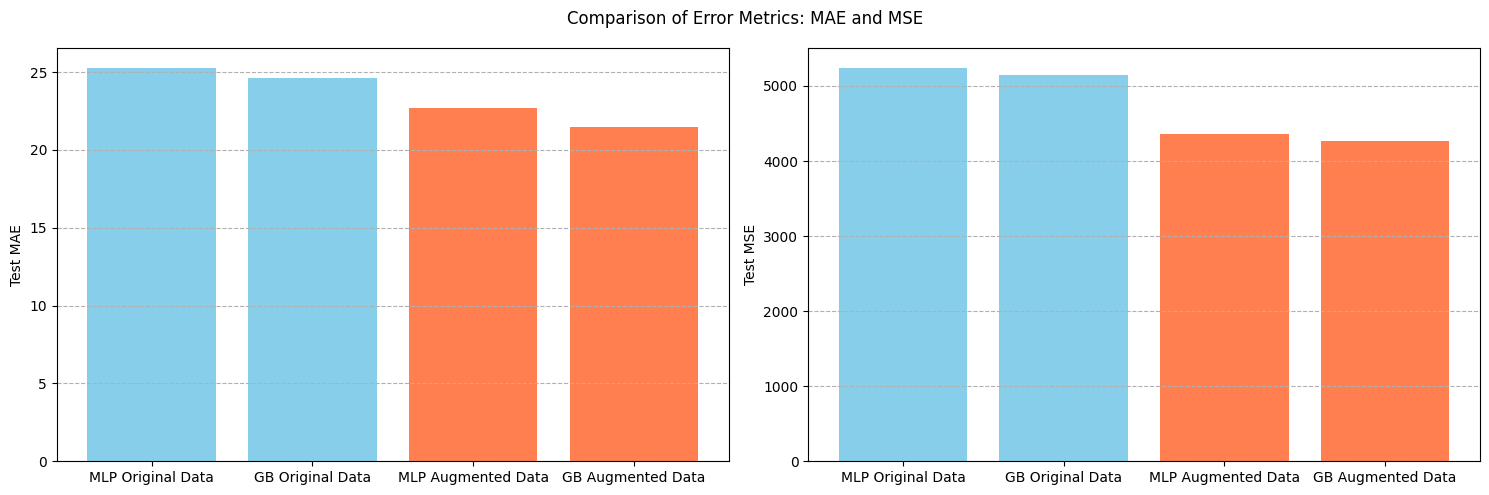

In [300]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

categories = ['MLP Original Data', 'GB Original Data', 'MLP Augmented Data', 'GB Augmented Data']
values_mae = [res.iloc[0, 0], res.iloc[2, 0], res.iloc[1, 0], res.iloc[3, 0]]
values_mse = [res.iloc[4, 0], res.iloc[6, 0], res.iloc[5, 0], res.iloc[7, 0]]

axes[0].bar(categories, values_mae, color=['skyblue', 'skyblue', 'coral', 'coral'])
axes[0].set_ylabel('Test MAE')
axes[0].grid(axis='y', linestyle='--', zorder=0)

axes[1].bar(categories, values_mse, color=['skyblue', 'skyblue', 'coral', 'coral'])
axes[1].set_ylabel('Test MSE')
axes[1].grid(axis='y', linestyle='--', zorder=0)

plt.suptitle('Comparison of Error Metrics: MAE and MSE');
plt.tight_layout()
plt.show()